<h1>Distributed Federated Learning with MNIST Data</h1>

<b>Importing the libraries</b>

<ul>
<li> Pytorch (to train the model)
<li> Pysyft (to train using federated approach)
</ul>

In [36]:
import pickle
import itertools
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import syft as sy
from syft.frameworks.torch.fl import utils
import pandas as pd
import itertools
import random
import datetime

In [37]:
class Parser:
     def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 60
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 30
        self.save_model = False
        self.num_of_workers = 3
    
args = Parser()
torch.manual_seed(args.seed)
kwargs = {'num_workers': 1, 'pin_memory': False}

<b>Download MNIST Data using torchvision datasets module</b>

In [38]:
train_loader = DataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    #.federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=1, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

<b>Creating architecture of the Neural Network model</b>

In [39]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def federated_avg(self, neighbour_model_params=None, current_worker=None):
        #Average two models weights
        
        params1 = self.state_dict()
        params2 = neighbour_model_params.copy()
      
        with torch.no_grad():
            for name1 in params1:
                if name1 in params2:
                    neighbour_ptr = params2[name1].copy()
                    neighbour_ptr.move(current_worker)
                    #print(current_worker, neighbour_ptr)
                    params1[name1] = (params1[name1]  + neighbour_ptr)/2
        
                    
        self.load_state_dict(params1, strict=False)
        
    

In [40]:
#Create events list for virutal workers exchange of parameters.
def create_events(num_of_workers):
    worker_events = list(itertools.combinations(range(1,num_of_workers+1),2))
    random.shuffle(worker_events)
    
    events_df = pd.DataFrame(worker_events,columns=['worker_id1','worker_id2'])
    events_df.index.names = ["batchnum"]
    return events_df

In [41]:
events_df = create_events(args.num_of_workers)
events_df

,worker_id1,worker_id2
batchnum,,
0,2,3
1,1,2
2,1,3


<b>Initilizer Function to create Virtual workers, initiate models and optimizers. Data will split amongst workers and trained.</b>

In [42]:
def initialize_workers():
    hook = sy.TorchHook(torch)
    compute_nodes = [sy.VirtualWorker(hook, id=f"worker-{i}") for i in range(args.num_of_workers)]
    remote_dataset = tuple(list() for _ in range(args.num_of_workers))
    input_worker_dataset = [list() for _ in range(args.num_of_workers)]
    target_worker_dataset = [list() for _ in range(args.num_of_workers)]
    target_counter = {}
    target_worker_split = {0:0, 1:1, 2:(2,0), 3:1, 4:0, 5:1, 6:2, 7:1, 8:(2,0), 9:2 }
    
    for batch_idx, (data,target) in enumerate(train_loader):
        target_value = target.item()
        
        if isinstance(target_worker_split[target_value], tuple):
            current_worker_idx = target_worker_split[target_value][0]
            target_worker_split[target_value] = tuple(reversed(target_worker_split[target_value]))
        else:
            current_worker_idx = target_worker_split[target.item()]
        
        if len(target_worker_dataset[current_worker_idx]) == args.batch_size:
            input_data , target_values = list(zip(*target_worker_dataset[current_worker_idx]))
            target_values = torch.cat(target_values)
            input_data = torch.cat(input_data)
            remote_data = input_data.send(compute_nodes[current_worker_idx])
            remote_target = target_values.send(compute_nodes[current_worker_idx])
            remote_dataset[current_worker_idx].append((remote_data, remote_target))
            target_worker_dataset[current_worker_idx] = list()
            
        
        target_worker_dataset[current_worker_idx].append((data, target))
            
        
    models = [Net() for _ in range(args.num_of_workers)]
    optimizers = [optim.SGD(models[i].parameters(), lr=args.lr) for i in range(args.num_of_workers)]
    return compute_nodes, remote_dataset, models, optimizers


In [44]:
def update(data, target, model, optimizer):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    return model

In [45]:
def exchange_parameters(models, data_index):
    #Get the workers ID from event dataframe to exchange parameters between two worker models.
    event_idx = data_index % len(events_df)
    event_row = events_df.loc[[event_idx]]
    worker_id1 = event_row['worker_id1'].values[0]-1
    worker_id2 = event_row['worker_id2'].values[0]-1
    worker1_model = models[worker_id1]
    worker2_model = models[worker_id2]
    worker1_params = worker1_model.state_dict()
    worker2_params = worker2_model.state_dict()
    
    #Send worker2 params to worker1 for averaging at worker1
    worker1_model.federated_avg(worker2_params, compute_nodes[worker_id1])
    
    #Send worker1 params to worker2 for averaging at worker2
    worker2_model.federated_avg(worker1_params, compute_nodes[worker_id2])

In [46]:
def train(models, compute_nodes, remote_dataset, optimizers, epoch_id, federated_average=False, exchange=False):
    
    if federated_average:
        models = [models.copy() for _ in range(args.num_of_workers)]
        optimizers = [optim.SGD(models[i].parameters(), lr=args.lr) for i in range(args.num_of_workers)]
        
    models = [model.send(compute_nodes[i]) for i, model in enumerate(models)]
    
    for remote_index in range(len(compute_nodes)):
        #print(f"Trip {data_index} and length of remote_dataset in {len(remote_dataset[0])} {len(remote_dataset[1])} {len(remote_dataset[2])}")
        for data_index in range(len(remote_dataset[remote_index])):
            data, target = remote_dataset[remote_index][data_index]
            models[remote_index] = update(data, target, models[remote_index], optimizers[remote_index])
        
    
    #Exchange of parameter between two remote models.
    if exchange:
        exchange_parameters(models, epoch_id)
        
    for model in models:
        model.get()
        
        
    #Federated Average
    if federated_average:
        model =  utils.federated_avg({f"worker-{i}":models[i] for i in range(len(compute_nodes))})
        return model

In [47]:
def test(federated_model, worker_id):
    federated_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = federated_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            prediction = output.argmax(1, keepdim=True)
            correct += prediction.eq(target.view_as(prediction)).sum().item()
           
        
    test_loss /= len(test_loader.dataset)
    avg_correct = correct / len(test_loader.dataset)
    print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_id, test_loss, avg_correct))
    return test_loss, avg_correct
    

In [48]:
def run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, exchange=False):
    model = Net()
    
    eval_results = []
    for epoch in range(args.epochs):
        start_time = time.time()
        print(f"Epoch Number {epoch + 1}")
        

        if not federated_average:
            train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, exchange)
            for worker_node, worker_model in zip(compute_nodes, models):
                avg_loss, avg_accuracy = test(worker_model, worker_node.id)
                results = {"worker_id" : worker_node.id,
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
                eval_results.append(results)
        else:
            
            federated_model = train(model, compute_nodes, remote_dataset, optimizers, epoch, federated_average, exchange)
            avg_loss, avg_accuracy = test(federated_model, "federated_avg_local")
            results = {"worker_id" : "federated_avg_local",
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
            eval_results.append(results)
            model = federated_model
            
        total_time = time.time() - start_time
        print('Communication time over the network', round(total_time, 2), 's\n')
    return eval_results

###  Simulation with training on individual workers on their local data

In [49]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
individual_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, exchange=False)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")    
    

Start time 2021-02-20 11:39:56.785143
Epoch Number 1
Test set for worker worker-0: Average loss: 6.3482 & Average Accuracy : 0.3825
Test set for worker worker-1: Average loss: 7.7068 & Average Accuracy : 0.3947
Test set for worker worker-2: Average loss: 6.3596 & Average Accuracy : 0.3802
Communication time over the network 76.59 s

Epoch Number 2
Test set for worker worker-0: Average loss: 6.3995 & Average Accuracy : 0.3853
Test set for worker worker-1: Average loss: 7.6604 & Average Accuracy : 0.3991
Test set for worker worker-2: Average loss: 6.5756 & Average Accuracy : 0.3844
Communication time over the network 78.51 s

Epoch Number 3
Test set for worker worker-0: Average loss: 6.3578 & Average Accuracy : 0.3870
Test set for worker worker-1: Average loss: 7.6394 & Average Accuracy : 0.4013
Test set for worker worker-2: Average loss: 6.6039 & Average Accuracy : 0.3871
Communication time over the network 78.22 s

Epoch Number 4
Test set for worker worker-0: Average loss: 6.3646 & Ave

Test set for worker worker-2: Average loss: 7.0873 & Average Accuracy : 0.3947
Communication time over the network 78.04 s

Epoch Number 29
Test set for worker worker-0: Average loss: 8.0291 & Average Accuracy : 0.3946
Test set for worker worker-1: Average loss: 9.0598 & Average Accuracy : 0.4038
Test set for worker worker-2: Average loss: 7.1281 & Average Accuracy : 0.3948
Communication time over the network 78.41 s

Epoch Number 30
Test set for worker worker-0: Average loss: 8.0906 & Average Accuracy : 0.3946
Test set for worker worker-1: Average loss: 9.1256 & Average Accuracy : 0.4039
Test set for worker worker-2: Average loss: 7.1753 & Average Accuracy : 0.3949
Communication time over the network 79.11 s

Epoch Number 31
Test set for worker worker-0: Average loss: 8.1560 & Average Accuracy : 0.3946
Test set for worker worker-1: Average loss: 9.1896 & Average Accuracy : 0.4039
Test set for worker worker-2: Average loss: 7.2117 & Average Accuracy : 0.3948
Communication time over the

Test set for worker worker-1: Average loss: 10.5557 & Average Accuracy : 0.4040
Test set for worker worker-2: Average loss: 8.4875 & Average Accuracy : 0.3952
Communication time over the network 79.79 s

Epoch Number 57
Test set for worker worker-0: Average loss: 9.8482 & Average Accuracy : 0.3948
Test set for worker worker-1: Average loss: 10.5980 & Average Accuracy : 0.4041
Test set for worker worker-2: Average loss: 8.5406 & Average Accuracy : 0.3952
Communication time over the network 78.8 s

Epoch Number 58
Test set for worker worker-0: Average loss: 9.9087 & Average Accuracy : 0.3948
Test set for worker worker-1: Average loss: 10.6511 & Average Accuracy : 0.4041
Test set for worker worker-2: Average loss: 8.5931 & Average Accuracy : 0.3952
Communication time over the network 79.25 s

Epoch Number 59
Test set for worker worker-0: Average loss: 9.9681 & Average Accuracy : 0.3948
Test set for worker worker-1: Average loss: 10.7047 & Average Accuracy : 0.4042
Test set for worker work

###  Simulation with training  with federated average

In [50]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
fedavg_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=True, exchange=False)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")    
    

Start time 2021-02-20 12:59:22.368413
Epoch Number 1
Test set for worker federated_avg_local: Average loss: 2.1824 & Average Accuracy : 0.1956
Communication time over the network 73.45 s

Epoch Number 2
Test set for worker federated_avg_local: Average loss: 0.9599 & Average Accuracy : 0.6595
Communication time over the network 74.8 s

Epoch Number 3
Test set for worker federated_avg_local: Average loss: 0.6190 & Average Accuracy : 0.8106
Communication time over the network 75.99 s

Epoch Number 4
Test set for worker federated_avg_local: Average loss: 0.4869 & Average Accuracy : 0.8557
Communication time over the network 75.88 s

Epoch Number 5
Test set for worker federated_avg_local: Average loss: 0.4111 & Average Accuracy : 0.8762
Communication time over the network 74.27 s

Epoch Number 6
Test set for worker federated_avg_local: Average loss: 0.3602 & Average Accuracy : 0.8913
Communication time over the network 76.35 s

Epoch Number 7
Test set for worker federated_avg_local: Average

Test set for worker federated_avg_local: Average loss: 0.1086 & Average Accuracy : 0.9664
Communication time over the network 71.24 s

Epoch Number 57
Test set for worker federated_avg_local: Average loss: 0.1083 & Average Accuracy : 0.9667
Communication time over the network 71.27 s

Epoch Number 58
Test set for worker federated_avg_local: Average loss: 0.1074 & Average Accuracy : 0.9675
Communication time over the network 72.35 s

Epoch Number 59
Test set for worker federated_avg_local: Average loss: 0.1074 & Average Accuracy : 0.9672
Communication time over the network 71.37 s

Epoch Number 60
Test set for worker federated_avg_local: Average loss: 0.1064 & Average Accuracy : 0.9676
Communication time over the network 71.92 s

Total time taken for simulation -1 is 4536.849951982498
End time 2021-02-20 14:14:59.218365


###  Simulation with training  with Decentralized federated average

In [51]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
decentrailized_fedavg_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, exchange=True)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")    
    

Start time 2021-02-20 14:14:59.226345
Epoch Number 1
Test set for worker worker-0: Average loss: 6.4179 & Average Accuracy : 0.3831
Test set for worker worker-1: Average loss: 2.1941 & Average Accuracy : 0.4349
Test set for worker worker-2: Average loss: 3.0567 & Average Accuracy : 0.3747
Communication time over the network 80.8 s

Epoch Number 2
Test set for worker worker-0: Average loss: 2.1448 & Average Accuracy : 0.4157
Test set for worker worker-1: Average loss: 2.8395 & Average Accuracy : 0.3892
Test set for worker worker-2: Average loss: 6.1207 & Average Accuracy : 0.3806
Communication time over the network 79.3 s

Epoch Number 3
Test set for worker worker-0: Average loss: 2.7172 & Average Accuracy : 0.1963
Test set for worker worker-1: Average loss: 7.0018 & Average Accuracy : 0.3975
Test set for worker worker-2: Average loss: 3.5647 & Average Accuracy : 0.3833
Communication time over the network 78.88 s

Epoch Number 4
Test set for worker worker-0: Average loss: 4.9274 & Avera

Test set for worker worker-2: Average loss: 0.9717 & Average Accuracy : 0.6895
Communication time over the network 79.95 s

Epoch Number 29
Test set for worker worker-0: Average loss: 0.4186 & Average Accuracy : 0.8692
Test set for worker worker-1: Average loss: 0.9492 & Average Accuracy : 0.7087
Test set for worker worker-2: Average loss: 2.7236 & Average Accuracy : 0.4447
Communication time over the network 80.0 s

Epoch Number 30
Test set for worker worker-0: Average loss: 1.2075 & Average Accuracy : 0.6561
Test set for worker worker-1: Average loss: 2.7959 & Average Accuracy : 0.4535
Test set for worker worker-2: Average loss: 1.7922 & Average Accuracy : 0.5381
Communication time over the network 81.04 s

Epoch Number 31
Test set for worker worker-0: Average loss: 1.9777 & Average Accuracy : 0.5190
Test set for worker worker-1: Average loss: 0.2722 & Average Accuracy : 0.8988
Test set for worker worker-2: Average loss: 0.8855 & Average Accuracy : 0.7126
Communication time over the 

Test set for worker worker-1: Average loss: 0.7504 & Average Accuracy : 0.7733
Test set for worker worker-2: Average loss: 2.0257 & Average Accuracy : 0.5348
Communication time over the network 87.84 s

Epoch Number 57
Test set for worker worker-0: Average loss: 0.9287 & Average Accuracy : 0.7351
Test set for worker worker-1: Average loss: 2.2997 & Average Accuracy : 0.5355
Test set for worker worker-2: Average loss: 1.3239 & Average Accuracy : 0.6431
Communication time over the network 86.16 s

Epoch Number 58
Test set for worker worker-0: Average loss: 1.5099 & Average Accuracy : 0.6063
Test set for worker worker-1: Average loss: 0.1631 & Average Accuracy : 0.9419
Test set for worker worker-2: Average loss: 0.5457 & Average Accuracy : 0.8154
Communication time over the network 88.38 s

Epoch Number 59
Test set for worker worker-0: Average loss: 0.3149 & Average Accuracy : 0.8918
Test set for worker worker-1: Average loss: 0.7398 & Average Accuracy : 0.7767
Test set for worker worker-

In [52]:
ind_train_df = pd.DataFrame(individual_train_results)
ind_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,worker-0,0,6.348225,0.3825
1,worker-1,0,7.706770,0.3947
2,worker-2,0,6.359591,0.3802
3,worker-0,1,6.399539,0.3853
4,worker-1,1,7.660449,0.3991
...,...,...,...,...
175,worker-1,58,10.704675,0.4042
176,worker-2,58,8.640426,0.3952
177,worker-0,59,10.027897,0.3948
178,worker-1,59,10.745183,0.4042


In [53]:
fedavg_train_df = pd.DataFrame(fedavg_train_results)
fedavg_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,federated_avg_local,0,2.182374,0.1956
1,federated_avg_local,1,0.959943,0.6595
2,federated_avg_local,2,0.619014,0.8106
3,federated_avg_local,3,0.486880,0.8557
4,federated_avg_local,4,0.411118,0.8762
5,federated_avg_local,5,0.360176,0.8913
6,federated_avg_local,6,0.321386,0.9019
7,federated_avg_local,7,0.291825,0.9116
8,federated_avg_local,8,0.268567,0.9184
9,federated_avg_local,9,0.249098,0.9240


In [54]:
decentrailized_fedavg_train_df = pd.DataFrame(decentrailized_fedavg_train_results)
decentrailized_fedavg_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,worker-0,0,6.417883,0.3831
1,worker-1,0,2.194108,0.4349
2,worker-2,0,3.056705,0.3747
3,worker-0,1,2.144761,0.4157
4,worker-1,1,2.839520,0.3892
...,...,...,...,...
175,worker-1,58,0.739766,0.7767
176,worker-2,58,1.979557,0.5423
177,worker-0,59,0.917919,0.7392
178,worker-1,59,2.271626,0.5405


### Plot Graph for Individual worker training accuracy over time.

In [55]:
#%matplotlib inline
#for key, grp in ind_train_df.groupby(['worker_id']):
#    grp.plot(x="epoch_idx", y="avg_accuracy", label=key, ylabel="avg_accuracy")



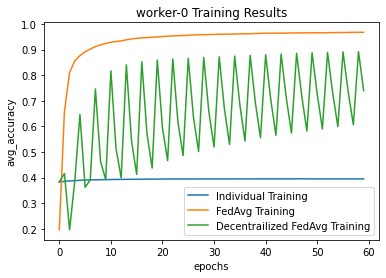

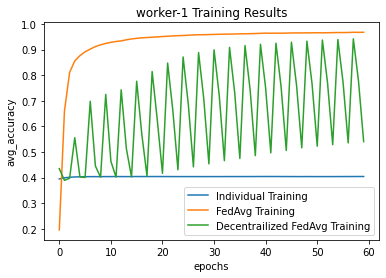

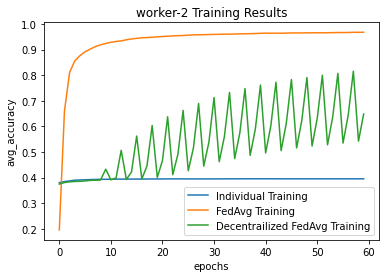

In [56]:
%matplotlib inline
ind_train_df
fedavg_train_df
decentrailized_fedavg_train_df
for node in compute_nodes:
    ind_worker_data  = ind_train_df[ind_train_df['worker_id']==node.id]
    plt.plot(ind_worker_data['epoch_idx'],ind_worker_data['avg_accuracy'], label="Individual Training")

    plt.plot(fedavg_train_df['epoch_idx'],fedavg_train_df['avg_accuracy'], label="FedAvg Training")
    
    decentral_worker_data  = decentrailized_fedavg_train_df[decentrailized_fedavg_train_df['worker_id']==node.id]
    plt.plot(decentral_worker_data['epoch_idx'],decentral_worker_data['avg_accuracy'], label="Decentrailized FedAvg Training")
    
    plt.xlabel('epochs')
    # Set the y axis label of the current axis.
    plt.ylabel('avg_accuracy')
    # Set a title of the current axes.
    plt.title(f'{node.id} Training Results')
    # show a legend on the plot
    plt.legend()
    # Display a figure.
    plt.show()